In [3]:
"""
!pip install mlflow
!pip install xgboost
"""

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
  Using cached xgboost-2.0.3-py3-none-win_amd64.whl.metadata (2.0 kB)
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 2.6 MB/s eta 0:00:39
   ---------------------------------------- 0.4/99.8 MB 5.4 MB/s eta 0:00:19
   ---------------------------------------- 0.7/99.8 MB 5.6 MB/s eta 0:00:18
   ---------------------------------------- 1.1/99.8 MB 6.3 MB/s eta 0:00:16
    --------------------------------------- 1.4/99.8 MB 6.2 MB/s eta 0:00:16
    --------------------------------------- 1.8/99.8 MB 7.0 MB/s eta 0:00:14
    --------------------------------------- 2.2/99.8 MB 7.4 MB/s eta 0:00:14
   - -------------------------------------- 2.7/99.8 MB 7.7 MB/s eta 0:00:13
   - ----------------------------------

# Import


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlflow

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("liver_patient_register")
EXP_ID = mlflow.get_experiment_by_name("liver_patient_register").experiment_id

# Dataset And Target Column Selection

In [4]:
SELECTED_DATASET = "indian-liver-patient.csv"
SELECTED_COLUMN = "Albumin"

# Data Preproccessing

In [5]:
df = pd.read_csv(SELECTED_DATASET)
# Drop rows with any NaN values
df_clean = df.dropna()
# Select categorical variables from df_clean
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the categorical variables
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols)
# Shuffle the dataset
df_shuffled = df_encoded.sample(frac=1).reset_index(drop=True)
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
numeric_columns_scaled = scaler.fit_transform(df_shuffled)

# Convert the scaled numeric columns back to a DataFrame
df_scaled = pd.DataFrame(numeric_columns_scaled, columns=df_shuffled.columns)
y = df_scaled[SELECTED_COLUMN]
X = df_scaled.drop(columns = [SELECTED_COLUMN])
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

In [21]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='rf_model', experiment_id = EXP_ID ) as run:
    # Fit model
    rf = RandomForestRegressor(n_estimators=100, max_depth=20)
    rf.fit(X_train, y_train)

    rf_preds = rf.predict(X_test)
    
    # Calculate the MSE
    rf_rms = mean_squared_error(y_test, rf_preds)

    # Save to MLFlow
    params = {
        "n_estimators": 100,
        "max_depth": 20
    }

    mlflow.set_tag("model_name", "RF")
    mlflow.log_params(params)

    mlflow.log_metric("test_rmse", rf_rms)
    mlflow.sklearn.log_model(rf, "sk_models" , registered_model_name="my_rf")
    

Successfully registered model 'my_rf'.
Created version '1' of model 'my_rf'.


# XGB

In [22]:
with mlflow.start_run(run_name='xgb_model', experiment_id = EXP_ID ) as run:

    # Create a DMatrix for the training and test sets
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set the parameters for the XGBoost model
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.7,
        'colsample_bytree': 0.7
    }

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(dtest, 'test')])

    # Make predictions on the test set
    y_pred = model.predict(dtest)

    # Calculate the MSE
    xgb_rms = mean_squared_error(y_test, y_pred)
    
    mlflow.set_tag("model_name", "XGB")
    mlflow.log_params(params)

    mlflow.log_metric("test_rmse", xgb_rms)
    mlflow.sklearn.log_model(xgb, "sk_models", registered_model_name="my_xgb")
    
    

[0]	test-rmse:0.91612
[1]	test-rmse:0.89876
[2]	test-rmse:0.82659
[3]	test-rmse:0.77672
[4]	test-rmse:0.71177
[5]	test-rmse:0.66929
[6]	test-rmse:0.63604
[7]	test-rmse:0.59016
[8]	test-rmse:0.55975
[9]	test-rmse:0.55278
[10]	test-rmse:0.51320
[11]	test-rmse:0.47848
[12]	test-rmse:0.46400
[13]	test-rmse:0.43586
[14]	test-rmse:0.41984
[15]	test-rmse:0.40042
[16]	test-rmse:0.38552
[17]	test-rmse:0.37295
[18]	test-rmse:0.35646
[19]	test-rmse:0.34518
[20]	test-rmse:0.32983
[21]	test-rmse:0.32124
[22]	test-rmse:0.31121
[23]	test-rmse:0.30259
[24]	test-rmse:0.30202
[25]	test-rmse:0.29662
[26]	test-rmse:0.29154
[27]	test-rmse:0.28508
[28]	test-rmse:0.27919
[29]	test-rmse:0.28077
[30]	test-rmse:0.27271
[31]	test-rmse:0.27060
[32]	test-rmse:0.26758
[33]	test-rmse:0.26426
[34]	test-rmse:0.25915
[35]	test-rmse:0.25671
[36]	test-rmse:0.25310
[37]	test-rmse:0.25164
[38]	test-rmse:0.24978
[39]	test-rmse:0.25027
[40]	test-rmse:0.24858
[41]	test-rmse:0.24656
[42]	test-rmse:0.24443
[43]	test-rmse:0.2436

2024/03/04 13:53:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Successfully registered model 'my_xgb'.
Created version '1' of model 'my_xgb'.


# KNN

In [23]:
with mlflow.start_run(run_name='knn_model5', experiment_id = EXP_ID ) as run:
    
    # Create Model with n_neighbors = k
    knn = KNeighborsRegressor(n_neighbors = 5)

    # Train the model
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    # Calculate the MSE
    knn_rms = mean_squared_error(y_test, y_pred)
    
    params = {
        "n_neighbors" : 5
    }
    
    
    mlflow.set_tag("model_name", "KNN5")
    mlflow.log_params(params)

    mlflow.log_metric("test_rmse", knn_rms)
    mlflow.sklearn.log_model(knn, "sk_models" , registered_model_name="my_knn")
    

Successfully registered model 'my_knn'.
Created version '1' of model 'my_knn'.


# Linear Regression

In [24]:
with mlflow.start_run(run_name='lin_reg_model', experiment_id = EXP_ID ) as run:

    # Fit a linear regression model to the polynomial features
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lin_reg.predict(X_test)

    # Calculate the MSE
    lin_reg_rms = mean_squared_error(y_test, y_pred)
        
    params = {}
            
    
    mlflow.set_tag("model_name", "LinReg")
    mlflow.log_params(params)

    mlflow.log_metric("test_rmse", lin_reg_rms)
    mlflow.sklearn.log_model(lin_reg, "sk_models" , registered_model_name="my_lin_reg")
    

Successfully registered model 'my_lin_reg'.
Created version '1' of model 'my_lin_reg'.


# SVR

In [25]:
with mlflow.start_run(run_name='svr_model', experiment_id = EXP_ID ) as run:

    # Fit the SVR model to the data
    svr = SVR(kernel='poly', C=100, epsilon=0.1, degree=5, gamma='auto')
    svr.fit(X, y.ravel())

    # Make predictions on the test set
    y_pred = svr.predict(X_test)

    # Calculate the MSE
    svr_rms = mean_squared_error(y_test, y_pred)

    params = {
        "kernel" : 'poly',
        "C" : 100, 
        "epsilon" : 0.1,
        "degree" : 5,
        "gamma" :'auto'
    }
            
    
    mlflow.set_tag("model_name", "SVR")
    mlflow.log_params(params)

    mlflow.log_metric("test_rmse", svr_rms)
    mlflow.sklearn.log_model(svr, "sk_models", registered_model_name="my_svr")
    

Successfully registered model 'my_svr'.
Created version '1' of model 'my_svr'.


# LASSO

In [26]:
with mlflow.start_run(run_name='lasso_model', experiment_id = EXP_ID ) as run:

    # Fit the Lasso regression model to the training data
    lasso = Lasso(alpha=0.2)
    lasso.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = lasso.predict(X_test)

    # Calculate the MSE
    lasso_rms = mean_squared_error(y_test, y_pred)
    
    
    params = {
        "alpha": 0.2
    }
            
    
    mlflow.set_tag("model_name", "Lasso")
    mlflow.log_params(params)

    mlflow.log_metric("test_rmse", lasso_rms)
    mlflow.sklearn.log_model(lasso, "sk_models", registered_model_name="my_lasso")


Successfully registered model 'my_lasso'.
Created version '1' of model 'my_lasso'.


# Ridge

In [27]:
with mlflow.start_run(run_name='ridge_model', experiment_id = EXP_ID ) as run:

    # Fit the Ridge regression model to the training data
    ridge = Ridge(alpha=0.2)
    ridge.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = ridge.predict(X_test)

    # Calculate the MSE
    ridge_rms = mean_squared_error(y_test, y_pred)    
    
    params = {
        "alpha": 0.2
    }
            
    
    mlflow.set_tag("model_name", "Ridge")
    mlflow.log_params(params)

    mlflow.log_metric("test_rmse", ridge_rms)
    mlflow.sklearn.log_model(ridge, "sk_models", registered_model_name="my_ridge")


Successfully registered model 'my_ridge'.
Created version '1' of model 'my_ridge'.


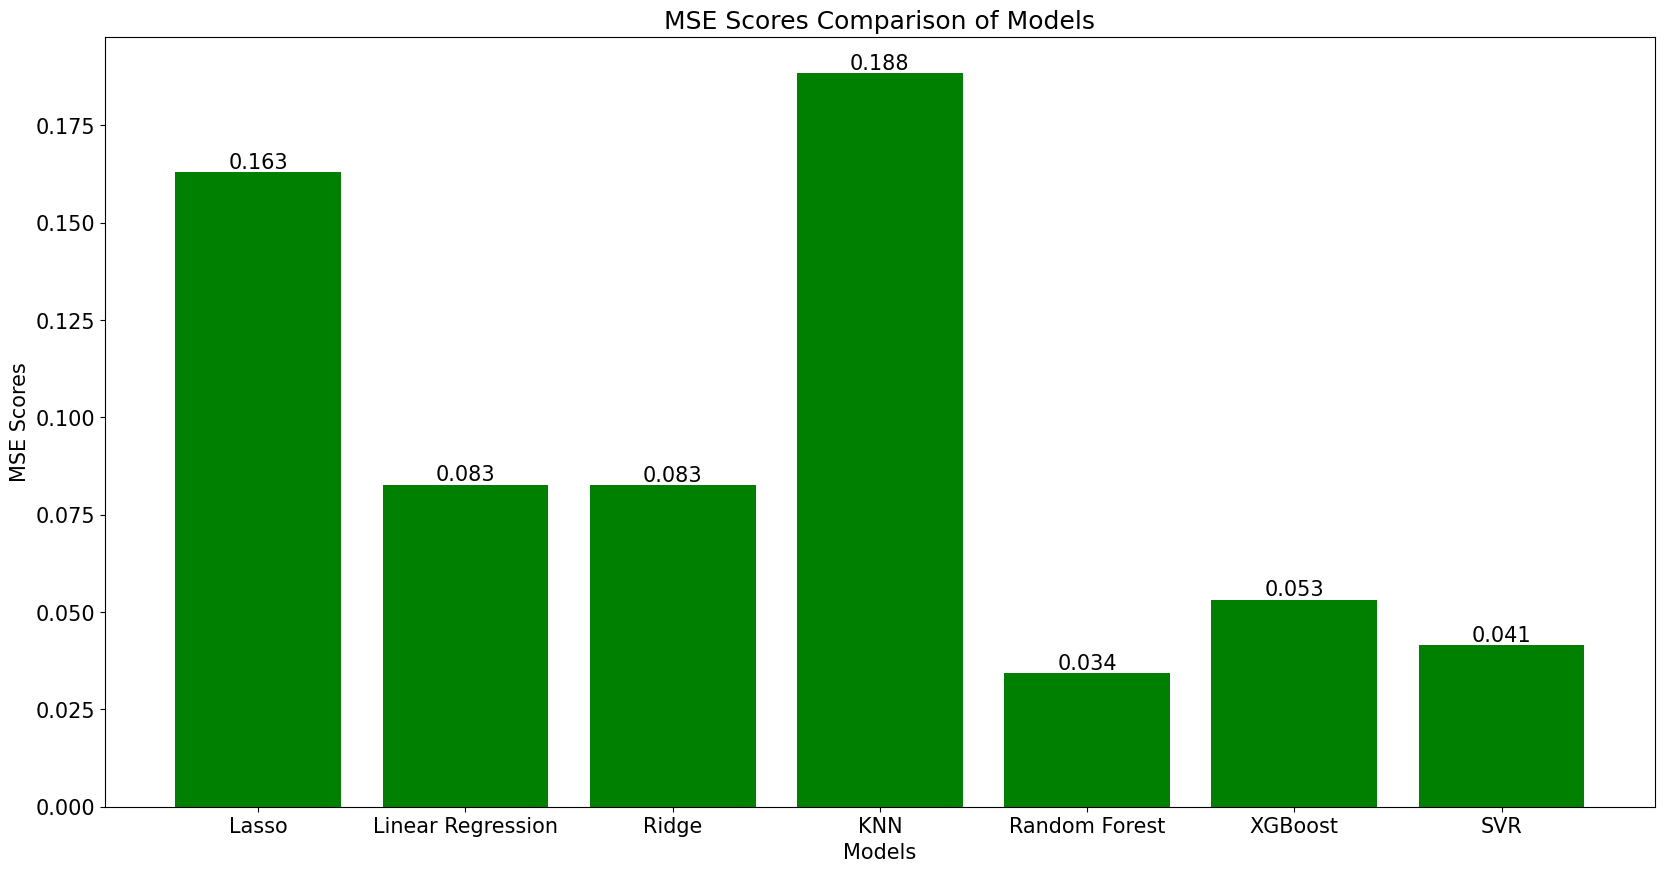

In [28]:
# Create a bar graph
x_list = ["Lasso", "Linear Regression","Ridge" ,"KNN","Random Forest","XGBoost","SVR"]
y_list = [lasso_rms, lin_reg_rms, ridge_rms ,knn_rms, rf_rms, xgb_rms, svr_rms]

plt.bar(x_list, y_list,  color = "green" )

# Add title and labels
plt.title('MSE Scores Comparison of Models')
plt.xlabel('Models')
plt.ylabel('MSE Scores')

# Add y values on the bars
for i, v in enumerate(y_list):
    plt.text(i, v, str(round(v,3)), ha='center', va='bottom')

# Show the plot
plt.show()

# Load 

In [41]:
# Load SVR
logged_model = 'runs:/e4035bb26fd442ec9e42c0dd711781cf/sk_models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

y_pred = loaded_model.predict(X_test)
new_svr_rms = mean_squared_error(y_test, y_pred)    


2024/03/04 14:04:05 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.10.2, required: mlflow==2.9.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


# Fetching an MLflow Model from the Model Registry


In [5]:
all_runs = mlflow.search_runs(search_all_experiments=True)
sorted_df = all_runs.sort_values(by=['metrics.test_rmse'], ascending=[True])

In [6]:
sorted_df[["tags.model_name","metrics.test_rmse"]]

,tags.model_name,metrics.test_rmse
12,SVR,0.030709
6,RF,0.034215
2,SVR,0.041429
15,RF,0.053043
5,XGB,0.053211
14,XGB,0.055348
7,RF,0.058737
10,Ridge,0.078906
13,LinReg,0.078923
0,Ridge,0.082623


In [7]:
sorted_df.loc[0]

run_id                                            98db093dd35941f488f9bfe6d89383bb
experiment_id                                                                    2
status                                                                    FINISHED
artifact_uri                     file:///C:/Users/izzet/OneDrive/Desktop/Dosyal...
start_time                                        2024-03-04 10:54:19.355000+00:00
end_time                                          2024-03-04 10:54:24.265000+00:00
metrics.test_rmse                                                         0.082623
params.alpha                                                                   0.2
params.C                                                                      None
params.degree                                                                 None
params.gamma                                                                  None
params.kernel                                                                 None
para